In [97]:
from typing import Tuple

import dgl
import torch 
from ogb.utils import smiles2graph
from ogb.lsc import DglPCQM4MDataset
import networkx as nx

import torch.nn as nn
import torch.nn.functional as F

In [5]:
dataset = DglPCQM4MDataset(root='/home/ksadowski/datasets', smiles2graph=smiles2graph)

In [6]:
dataset

DglPCQM4MDataset(3803453)

Num nodes: 7
Num edges: 12
Num source nodes: 7


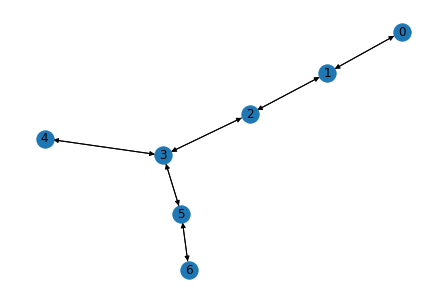

In [106]:
molecule = dgl.to_homogeneous(dataset[2736][0], ndata=dataset[2736][0].ndata, edata=dataset[2736][0].edata, store_type=False)
molecule_lg = dgl.line_graph(molecule, backtracking=False)

# molecule = dgl.add_self_loop(molecule)

print(f'Num nodes: {molecule.num_nodes()}')
print(f'Num edges: {molecule.num_edges()}')
print(f'Num source nodes: {molecule.num_src_nodes()}')

nx.draw_kamada_kawai(molecule.to_networkx(), with_labels=True)

In [8]:
for i in range(molecule.num_edges()):
    source_edge = molecule_lg.edges()[0][i].item()
    destination_edge = molecule_lg.edges()[1][i].item()

    print(molecule.find_edges(source_edge))
    print(molecule.find_edges(destination_edge))
    print()

for i in range(molecule.num_edges()):
    print(molecule.find_edges(i))


(tensor([0]), tensor([1]))
(tensor([1]), tensor([2]))

(tensor([1]), tensor([2]))
(tensor([2]), tensor([3]))

(tensor([2]), tensor([1]))
(tensor([1]), tensor([0]))

(tensor([2]), tensor([3]))
(tensor([3]), tensor([4]))

(tensor([2]), tensor([3]))
(tensor([3]), tensor([5]))

(tensor([3]), tensor([2]))
(tensor([2]), tensor([1]))

(tensor([4]), tensor([3]))
(tensor([3]), tensor([2]))

(tensor([4]), tensor([3]))
(tensor([3]), tensor([5]))

(tensor([3]), tensor([5]))
(tensor([5]), tensor([6]))

(tensor([5]), tensor([3]))
(tensor([3]), tensor([2]))

(tensor([5]), tensor([3]))
(tensor([3]), tensor([4]))

(tensor([6]), tensor([5]))
(tensor([5]), tensor([3]))

(tensor([0]), tensor([1]))
(tensor([1]), tensor([0]))
(tensor([1]), tensor([2]))
(tensor([2]), tensor([1]))
(tensor([2]), tensor([3]))
(tensor([3]), tensor([2]))
(tensor([3]), tensor([4]))
(tensor([4]), tensor([3]))
(tensor([3]), tensor([5]))
(tensor([5]), tensor([3]))
(tensor([5]), tensor([6]))
(tensor([6]), tensor([5]))


(tensor([ 0,  2,  3,  4,  4,  5,  7,  7,  8,  9,  9, 11]), tensor([ 2,  4,  1,  6,  8,  3,  5,  8, 10,  5,  6,  9]))
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


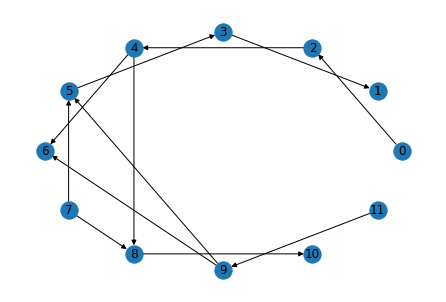

In [10]:
print(molecule_lg.edges())
print(molecule_lg.adjacency_matrix().to_dense())

nx.draw_circular(molecule_lg.to_networkx(), with_labels=True)

In [118]:
class SelfAttention(nn.Module):
    def __init__(self, in_feats):
        super().__init__()
        self.key_linear = nn.Linear(in_feats, 1)
        self.value_linear = nn.Linear(in_feats, in_feats)

    def forward(self, inputs):
        key = self.key_linear(inputs)
        value = self.value_linear(inputs)

        x = value @ inputs.t() @ key
        x = F.softmax(x, dim=0)

        return x

class MutualAttentionGraphConv(nn.Module):
    def __init__(self, in_feats, aggregation_function: str):
        super().__init__()
        self.aggregation_function = aggregation_function
        self.linear = nn.Linear(in_feats, in_feats)

    def forward(self, inputs: torch.Tensor(), attention_adjacency: torch.Tensor()):
        if self.aggregation_function == 'sum':
            x = attention_adjacency @ inputs
        elif self.aggregation_function == 'mean':
            degree = torch.diag(torch.count_nonzero(attention_adjacency, dim=1))
            degree_inverse = torch.linalg.inv(degree.float())

            x = degree_inverse @ attention_adjacency @ inputs

        x = self.linear(x)

        return x


class Head(nn.Module):
    def __init__(self, node_in_feats: int, edge_in_feats: int) -> None:
        super().__init__()
        self.node_attention = SelfAttention(node_in_feats)
        self.node_query_linear = nn.Linear(node_in_feats, node_in_feats)
        self.node_query_conv = MutualAttentionGraphConv(node_in_feats, 'mean')
        self.edge_attention = SelfAttention(edge_in_feats)
        self.edge_query_linear = nn.Linear(edge_in_feats, edge_in_feats)
        self.edge_query_conv = MutualAttentionGraphConv(edge_in_feats, 'sum')

    def create_mutual_node_attention_adjacency(self, g: dgl.DGLGraph, edge_attention: torch.Tensor) -> torch.Tensor:
        node_adjacency = g.adj().to_dense()

        for edge in range(g.num_edges()):
            nodes = g.find_edges(edge)

            source_node = nodes[0].item()
            destination_node = nodes[1].item()

            node_adjacency[source_node][destination_node] = edge_attention[edge]

        return node_adjacency


    def create_mutual_edge_attention_adjacency(self, g: dgl.DGLGraph, lg: dgl.DGLGraph, node_attention: torch.Tensor) -> torch.Tensor:
        edge_adjacency = lg.adj().to_dense()

        for node in range(lg.num_edges()):
            edges = lg.find_edges(node)

            source_edge = edges[0].item()
            destination_edge = edges[1].item()

            connecting_node = g.find_edges(source_edge)[1]
            
            edge_adjacency[source_edge][destination_edge] = node_attention[connecting_node]

        return edge_adjacency


    def forward(
        self, 
        g: dgl.DGLGraph, 
        lg: dgl.DGLGraph, 
        node_feats: torch.Tensor, 
        edge_feats: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_attention = self.node_attention(node_feats)
        edge_attention = self.edge_attention(edge_feats)
        
        node_mutual_attention_adjacency = self.create_mutual_node_attention_adjacency(g, edge_attention)
        node_query = self.node_query_linear(node_feats)
        node_query = self.node_query_conv(node_query, node_mutual_attention_adjacency)

        edge_mutual_attention_adjacency = self.create_mutual_edge_attention_adjacency(g, lg, node_attention)
        edge_query = self.edge_query_linear(edge_feats)
        edge_query = self.edge_query_conv(edge_query, edge_mutual_attention_adjacency)
        
        return node_query, edge_query

node_feats = molecule.ndata['feat'].float()
edge_feats = molecule.edata['feat'].float()

node_out_1, edge_out_1 = Head(9, 3)(molecule, molecule_lg, node_feats, edge_feats)
node_out_2, edge_out_2 = Head(9, 3)(molecule, molecule_lg, node_feats, edge_feats)

print(node_out_2, edge_out_2)


tensor([[-0.1189, -0.1914,  0.1481,  0.0569,  0.1306, -0.1228,  0.2583, -0.0915,
         -0.0337],
        [-0.1935, -0.1471,  0.1226,  0.0999,  0.0738, -0.0256,  0.1515, -0.1289,
         -0.0266],
        [-0.1913, -0.1469,  0.1209,  0.1029,  0.0697, -0.0279,  0.1523, -0.1235,
         -0.0271],
        [-0.1995, -0.1372,  0.1376,  0.0663,  0.0777, -0.0711,  0.1580, -0.1083,
          0.0195],
        [-0.2645, -0.0905,  0.0803,  0.1666, -0.0293,  0.0569,  0.0350, -0.1194,
         -0.0088],
        [-0.1298, -0.1820,  0.1481,  0.0570,  0.1228, -0.1178,  0.2457, -0.0944,
         -0.0258],
        [-0.1407, -0.1759,  0.1451,  0.0569,  0.1148, -0.1136,  0.2325, -0.0919,
         -0.0149]], grad_fn=<AddmmBackward>) tensor([[ 0.0698, -0.4536,  0.0428],
        [ 0.1698, -0.4920,  0.0884],
        [ 0.1547, -0.5243, -0.0235],
        [ 0.1547, -0.5243, -0.0235],
        [ 0.1691, -0.4920,  0.0874],
        [ 0.0698, -0.4536,  0.0428],
        [ 0.1698, -0.4920,  0.0884],
        [ 0.169

In [74]:
edge_adjacency = molecule_lg.adj().to_dense()
# mask = torch.tensor([[molecule.find_edges(i)[1]] for i in range(molecule.num_edges())])

node_attention = attentions[0]

# edge_attention_from_node = torch.tensor([[node_attention[molecule.find_edges(edge)[1]]] for edge in range(molecule.num_edges())])

# molecule_lg.adjacency_matrix().to_dense() * edge_attention_from_node @ molecule.edata['feat'].float()

for i in range(molecule_lg.num_edges()):
    edges = molecule_lg.find_edges(i)
    source_edge  = edges[0].item()
    destination_edge = edges[1].item()
    connecting_node = molecule.find_edges(source_edge)[1]

    assert molecule.find_edges(source_edge)[1] == molecule.find_edges(destination_edge)[0]

    edge_adjacency[source_edge][destination_edge] = node_attention[connecting_node]

print(node_attention)
print(edge_adjacency)




tensor([[7.4651e-01],
        [1.2672e-01],
        [1.2672e-01],
        [4.0631e-05],
        [3.4036e-20],
        [2.2211e-15],
        [3.3049e-11]], grad_fn=<SoftmaxBackward>)
tensor([[0.0000e+00, 0.0000e+00, 1.2672e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2672e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.2672e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         4.0631e-05, 0.0000e+00, 4.0631e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00],
   

In [32]:
molecule.edges()

(tensor([0, 1, 1, 2, 2, 3, 3, 4, 3, 5, 5, 6]),
 tensor([1, 0, 2, 1, 3, 2, 4, 3, 5, 3, 6, 5]))

In [57]:
edge_attention = attentions[1]
node_adjacency = molecule.adj().to_dense()

for i in range(molecule.num_edges()):
    nodes = molecule.find_edges(i)
    source_node = nodes[0].item()
    destination_node = nodes[1].item()
    node_adjacency[source_node][destination_node] = edge_attention[i]


print(edge_attention)
print(node_adjacency)

tensor([[0.0437],
        [0.0437],
        [0.0327],
        [0.0327],
        [0.0437],
        [0.0437],
        [0.0327],
        [0.0327],
        [0.0437],
        [0.0437],
        [0.3034],
        [0.3034]], grad_fn=<SoftmaxBackward>)
tensor([[0.0000, 0.0437, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0437, 0.0000, 0.0327, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0327, 0.0000, 0.0437, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0437, 0.0000, 0.0327, 0.0437, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0327, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0437, 0.0000, 0.0000, 0.3034],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3034, 0.0000]],
       grad_fn=<CopySlices>)


In [60]:
node_adjacency @ node_feats


tensor([[0.2185, 0.0000, 0.1311, 0.2185, 0.0437, 0.0000, 0.0437, 0.0000, 0.0000],
        [0.4260, 0.0000, 0.2294, 0.3823, 0.1202, 0.0000, 0.0765, 0.0000, 0.0000],
        [0.3823, 0.0000, 0.2294, 0.3823, 0.0327, 0.0000, 0.0765, 0.0000, 0.0000],
        [0.7537, 0.0000, 0.2513, 0.6008, 0.0437, 0.0000, 0.1202, 0.0000, 0.0000],
        [0.1637, 0.0000, 0.0982, 0.1637, 0.0000, 0.0000, 0.0327, 0.0000, 0.0000],
        [2.3422, 0.0000, 0.7379, 1.7355, 0.3034, 0.0000, 0.6505, 0.0000, 0.0000],
        [2.1237, 0.0000, 0.6068, 1.5169, 0.0000, 0.0000, 0.3034, 0.0000, 0.0000]],
       grad_fn=<MmBackward>)

In [90]:
molecule_lg.adj().to_dense()

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [117]:
nn.Conv2d(9, 7, kernel_size=1)(node_feats[:None, ])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [7, 9, 1, 1], but got 2-dimensional input of size [7, 9] instead